# Title

Importing relevant libraries

In [1]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns

In [2]:
trainingAmount = 100000
testAmount = 25000

df_train = pd.read_json('training' + str(trainingAmount) +'.json', lines=True)
df_test = pd.read_json('test' + str(testAmount) +'.json', lines=True)

df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

## Defining the clean method

In [3]:
def clean(text):
    from nltk.stem import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    from nltk.tokenize import word_tokenize
    
     # Empty question
    if type(text) != str:
        return ''
    
    text = text.lower()
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    text = re.sub('[' + string.punctuation + ']', ' ', text)

    text = re.sub('im', "", text)

    
    #Tokenizing text for normalizing more easily
    tokenized_text = word_tokenize(text)
    
    
    
    #Removing stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    kept_words = ['he', 'she', 'they', 'we']
    for kw in kept_words:
        stopwords.remove(kw)
    
    tokenized_text = [w for w in tokenized_text if not w in stopwords] 
    
    
    #Removing numbers
    tokenized_text = [w for w in tokenized_text if w.isalpha()]
    
    
    #Putting tokens back together as a string
    text = ''
    for token in tokenized_text:
        text += token + ' '
        
    
    # Return a list of words
    return text

In [4]:
df_train['length'] = df_train['text'].apply(len)
df_test['length'] = df_test['text'].apply(len)

In [5]:
df_train.describe()

,stars,useful,funny,cool,length
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,3.736920,1.279980,0.442580,0.54412,586.933740
std,1.454589,2.919489,1.648487,2.04579,548.694712
min,1.000000,0.000000,0.000000,0.00000,1.000000
25%,3.000000,0.000000,0.000000,0.00000,232.000000
50%,4.000000,0.000000,0.000000,0.00000,416.000000
75%,5.000000,1.000000,0.000000,0.00000,746.000000
max,5.000000,101.000000,74.000000,94.00000,5000.000000


Cleaning the data

In [6]:
df_train['cleaned_text'] = df_train['text'].apply(clean)
df_test['cleaned_text'] = df_test['text'].apply(clean)

Saving all the necessary data in arrays

In [7]:
df_test

,text,stars,useful,funny,cool,length,cleaned_text
0,Awesome results. They take the time to answer ...,5,0,0,0,150,awesome results they take te answer every ques...
1,So disappointing we went there to waste time b...,1,0,0,0,819,disappointing we went waste te we waiting shut...
2,"Nice atmosphere, good quality and fast service...",5,0,0,0,494,nice atmosphere good quality fast service defi...
3,This is my go to spot to get supplements! They...,5,1,1,1,161,go spot get supplements they great prices ofte...
4,Ottima la cipolla fritta tagliata solamente me...,5,0,0,0,201,otta la cipolla fritta tagliata solamente metà...
5,"Enjoyed Guy's show immensely, unfortunately th...",1,0,0,0,332,enjoyed guy show mensely unfortunately place l...
6,I'm here at least once a week. This location i...,5,1,0,0,454,least week location little crowded hard get so...
7,Ew this place sucked. All the Section 8/ ghet...,2,0,0,0,450,ew place sucked section ghetto type people inf...
8,Normally eat here once every two weeks. Haven'...,2,0,0,0,609,normally eat every two weeks problems got pick...
9,[ ] current hepatitis shot [ ] current TB. sho...,2,3,4,1,741,current hepatitis shot current tb shot able ch...


In [8]:
train = df_train['cleaned_text'].values
test = df_test['cleaned_text'].values
trainStars = df_train['stars'].values
testStars = df_test['stars'].values

## BOW model with Naïve Bayes Classifier

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

In [10]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [11]:
testStars_predicted = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

60.096000000000004 %


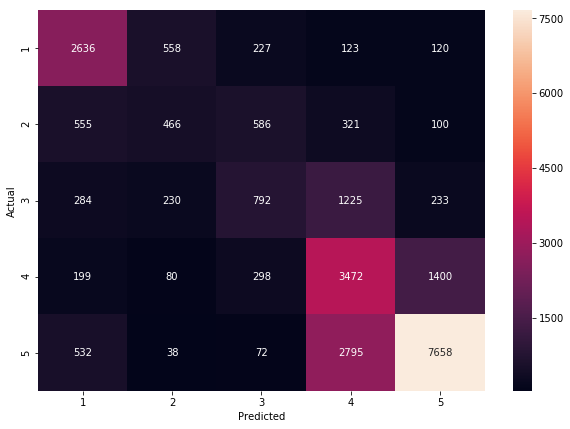

In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


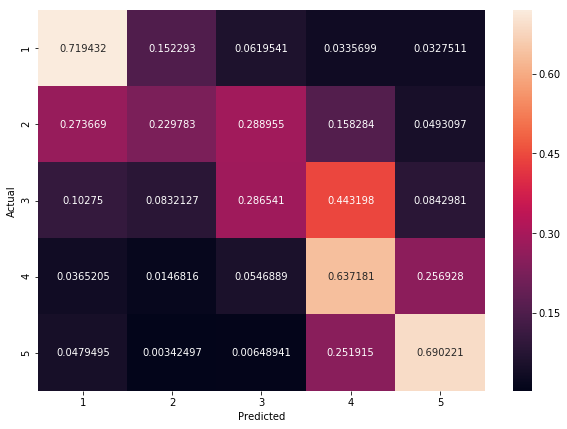

In [13]:
confusion_matrix_proportions = []
for n in range(confusion_matrix.shape[0]):
    confusion_matrix_proportions.append(confusion_matrix[n,:]/df_test.groupby('stars').count().at[n+1, 'text'])
    
confusion_matrix_proportions = num.array(confusion_matrix_proportions)

df_cm = pd.DataFrame(confusion_matrix_proportions, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [14]:
import collections
distance = num.abs(testStars - testStars_predicted)
collections.Counter(distance)

Counter({0: 15024, 1: 7647, 3: 460, 2: 1217, 4: 652})

## Word2Vec model
Tokenizing the words

In [15]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

train_tokenized = [word_tokenize(token) for token in train]
test_tokenized = [word_tokenize(token) for token in test]
word2vec = Word2Vec(train_tokenized, min_count=10)

word2vec.init_sims(replace=True)

In [16]:
def sent2vec(reviewTok):
    vecSize = len(word2vec.wv[reviewTok[0][0]])
    reviewVec = []
    for sentence in reviewTok:
        vectorSum = num.zeros(vecSize)
        empty = True
        for token in sentence:
            if token in word2vec.wv.vocab:
                vectorSum += word2vec.wv[token]
                empty = False
        if not empty:
            vectorSum = vectorSum / num.sqrt((vectorSum ** 2).sum())
        reviewVec.append(vectorSum)
    return num.array(reviewVec)

In [17]:
train_vectors = sent2vec(train_tokenized)
test_vectors = sent2vec(test_tokenized)

### XGBoost classifier

In [18]:
from xgboost import XGBClassifier
xgbclassifier = XGBClassifier()
xgbclassifier.fit(train_vectors, trainStars)
print(xgbclassifier.score(test_vectors, testStars)*100, '%')

62.083999999999996 %


### Support Vector  Machine classifier

In [ ]:
from sklearn.svm import SVC
svc = SVC(gamma='auto', C=2)
svc.fit(train_vectors, trainStars)
print(svc.score(test_vectors, testStars)*100, '%')

***

### Looking for relation between text length and rating
Tests with charts

In [ ]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

In [ ]:
sns.boxplot(x='stars', y='length', data=df_test)

In [ ]:
df_test.describe()

In [ ]:
starProp_train = df_train.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_train['percentage'] = starProp_train['cleaned_text'] / df_train.shape[0] * 100
starProp_train


In [ ]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_test['percentage'] = starProp_test['cleaned_text'] / df_test.shape[0] * 100
starProp_test


Training and test set have same proportions! :-)

ideas:
- make a numbers token <NUMBER>
- stem the words
- remove stopwords
- create a personal noun token <PERSONALNOUN>